### Recommending `Teachers` to `Students` for the K-12 online one-on-one courses

1. Pseudo Matching Score Module - provide reliable training labels
2. Ranking Module - scores every candidate teacher
3. Novelty Boosting Module - gives additional opportunities to new teachers
4. Diversity Module - guardrails the recommended results to reduce the chance of collision

| Challenge          | Description                        | Workaround        |
| ------------------ | ---------------------------------- | ----------------- |
| Limited sizes of demand and supply | The number of teachers in supply side is incredibly smaller compared to Internet-scaled inventories. Moreover, different from item based recommendation where popular items can be suggested to millions of users simultaneously, a teacher can only take a very limited amount of students and students may only take one or two classes at each semester. | - |
| Lack of gold standard | There is no ground truth showing how good a match is between a teacher and a student. The rating based mechanism doesn’t work since ratings from K-12 students are very noisy and unreliable. | Pseudo Matching Score Module |
| Cold-start teachers | The online educational marketplace is dynamic and there are always new teachers joining. It is important to give such new teachers opportunities to let them take students instead of keeping recommending existing best performing teachers. | Novelty Boosting Module |
| High-demand diversity | It is undesirable to recommend the same set of teachers to students and the teacher recommender systems are supposed to reduce chances that two students want to book the same teacher at the same time. | Diversity Module |

## Setup

In [ ]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

np.random.seed(42)
%matplotlib inline
tqdm.pandas()

## Generate Synthetic Data

In [2]:
teacher_set = np.arange(200)
student_set = np.arange(300)
gender_set = ['male','female']
school_set = ['school1','school2']
talking_time = ['short','long']

In [3]:
df = pd.DataFrame(list(product(teacher_set, student_set)), columns=['teacherid', 'studentid'])

df2 = pd.DataFrame(list(product(np.random.choice(teacher_set, int(len(teacher_set)/2)),
                                np.random.choice(student_set, int(len(student_set)/2)))),
                       columns=['teacherid', 'studentid'])

df = pd.concat([df, df2], ignore_index=True, sort=False)

df = df.rename_axis('session_id').reset_index()

df['status'] = np.random.choice(['completed','dropped','not_taken'],len(df),p=[0.05,0.1,0.85])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   session_id  75000 non-null  int64 
 1   teacherid   75000 non-null  int64 
 2   studentid   75000 non-null  int64 
 3   status      75000 non-null  object
dtypes: int64(3), object(1)
memory usage: 2.3+ MB


In [4]:
df.head(10)

,session_id,teacherid,studentid,status
0,0,0,0,not_taken
1,1,0,1,not_taken
2,2,0,2,not_taken
3,3,0,3,not_taken
4,4,0,4,not_taken
5,5,0,5,not_taken
6,6,0,6,not_taken
7,7,0,7,not_taken
8,8,0,8,not_taken
9,9,0,9,not_taken


In [5]:
df_s = pd.DataFrame(student_set, columns=['studentid'])
df_s['gender'] = np.random.choice(gender_set,len(df_s),p=[0.4, 0.6])
df_s['school'] = np.random.choice(school_set,len(df_s),p=[0.3, 0.7])
df_s['talking_time'] = np.random.choice(talking_time,len(df_s),p=[0.8, 0.2])
df_s

,studentid,gender,school,talking_time
0,0,female,school2,short
1,1,male,school2,short
2,2,female,school1,short
3,3,male,school2,long
4,4,male,school2,long
...,...,...,...,...
295,295,male,school2,short
296,296,female,school2,short
297,297,male,school2,long
298,298,female,school1,short


In [6]:
df_t = pd.DataFrame(teacher_set, columns=['teacherid'])
df_t['gender'] = np.random.choice(gender_set,len(df_t),p=[0.7, 0.3])
df_t['school'] = np.random.choice(school_set,len(df_t),p=[0.4, 0.6])
df_t['talking_time'] = np.random.choice(talking_time,len(df_t),p=[0.6, 0.4])
df_t

,teacherid,gender,school,talking_time
0,0,female,school2,short
1,1,female,school1,long
2,2,female,school2,short
3,3,male,school2,short
4,4,male,school2,long
...,...,...,...,...
195,195,male,school1,short
196,196,female,school1,long
197,197,male,school1,long
198,198,male,school2,short


In [7]:
df = df.merge(df_s, on='studentid').merge(df_t, on='teacherid', suffixes=('_student','_teacher'))
df

,session_id,teacherid,studentid,status,gender_student,school_student,talking_time_student,gender_teacher,school_teacher,talking_time_teacher
0,0,0,0,not_taken,female,school2,short,female,school2,short
1,1,0,1,not_taken,male,school2,short,female,school2,short
2,2,0,2,not_taken,female,school1,short,female,school2,short
3,3,0,3,not_taken,male,school2,long,female,school2,short
4,4,0,4,not_taken,male,school2,long,female,school2,short
...,...,...,...,...,...,...,...,...,...,...
74995,59996,199,296,not_taken,female,school2,short,female,school2,short
74996,59997,199,297,not_taken,male,school2,long,female,school2,short
74997,73335,199,297,not_taken,male,school2,long,female,school2,short
74998,59998,199,298,not_taken,female,school1,short,female,school2,short


In [8]:
dfx = df.copy()

# logical filter - student and teachers belong to same school
dfx = dfx[dfx['school_student']==dfx['school_teacher']]
dfx.drop('school_teacher', axis=1, inplace=True)
dfx.rename(columns={'school_student':'school'}, inplace=True)

# in school1, female students prefer female teacher
subset = dfx.loc[(dfx['school']=='school1') & (dfx['gender_student']=='female') & (dfx['gender_teacher']=='female'),'status']
dfx.loc[subset.index,'status'] = np.random.choice(['completed','dropped','not_taken'],len(subset),p=[0.4,0.1,0.5])

# in school2, male students prefer female teacher
subset = dfx.loc[(dfx['school']=='school2') & (dfx['gender_student']=='male') & (dfx['gender_teacher']=='female'),'status']
dfx.loc[subset.index,'status'] = np.random.choice(['completed','dropped','not_taken'],len(subset),p=[0.4,0.1,0.5])

# in school1, students prefer teacher who talk long
subset = dfx.loc[(dfx['school']=='school1') & (dfx['talking_time_teacher']=='long'),'status']
dfx.loc[subset.index,'status'] = np.random.choice(['completed','dropped','not_taken'],len(subset),p=[0.4,0.1,0.5])

# in school2, students prefer teacher who talk short
subset = dfx.loc[(dfx['school']=='school2') & (dfx['talking_time_teacher']=='short'),'status']
dfx.loc[subset.index,'status'] = np.random.choice(['completed','dropped','not_taken'],len(subset),p=[0.4,0.1,0.5])

In [9]:
dfx

,session_id,teacherid,studentid,status,gender_student,school,talking_time_student,gender_teacher,talking_time_teacher
0,0,0,0,not_taken,female,school2,short,female,short
1,1,0,1,completed,male,school2,short,female,short
3,3,0,3,not_taken,male,school2,long,female,short
4,4,0,4,completed,male,school2,long,female,short
5,5,0,5,completed,female,school2,short,female,short
...,...,...,...,...,...,...,...,...,...
74994,59995,199,295,not_taken,male,school2,short,female,short
74995,59996,199,296,not_taken,female,school2,short,female,short
74996,59997,199,297,dropped,male,school2,long,female,short
74997,73335,199,297,completed,male,school2,long,female,short


Let's checkout some patterns that we engineered

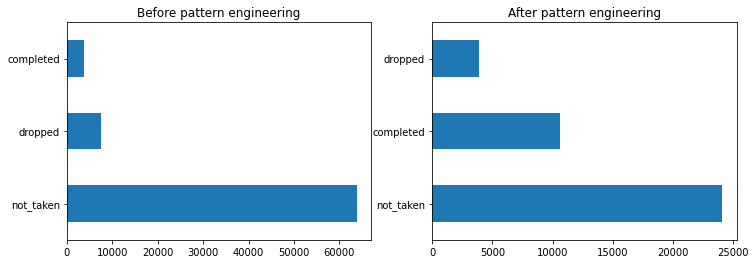

In [10]:
# status count in general
figure, axes = plt.subplots(1, 2, figsize=(12,4))
df.loc[:,'status'].value_counts().plot(kind='barh', ax=axes[0], title='Before pattern engineering');
dfx.loc[:,'status'].value_counts().plot(kind='barh', ax=axes[1], title='After pattern engineering');

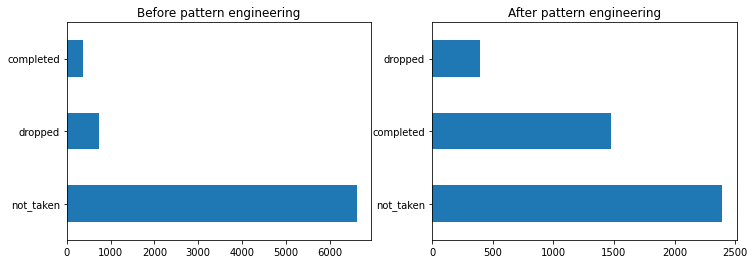

In [11]:
# status count for long-talking students to short-talking teachers
figure, axes = plt.subplots(1, 2, figsize=(12,4))
df.loc[(df['talking_time_student']=='long') & (df['talking_time_teacher']=='short'),'status'].value_counts().plot(kind='barh', ax=axes[0], title='Before pattern engineering');
dfx.loc[(dfx['talking_time_student']=='long') & (dfx['talking_time_teacher']=='short'),'status'].value_counts().plot(kind='barh', ax=axes[1], title='After pattern engineering');

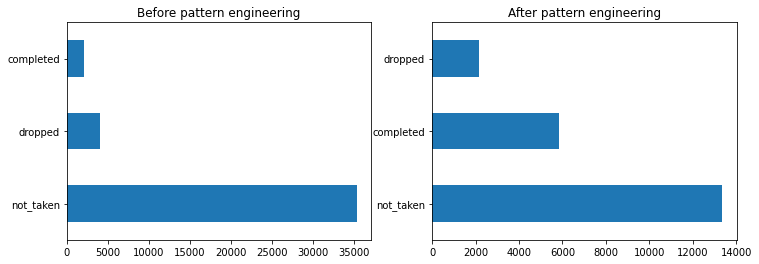

In [12]:
# status count for female student preference
figure, axes = plt.subplots(1, 2, figsize=(12,4))
df.loc[(df['gender_student']=='female'),'status'].value_counts().plot(kind='barh', ax=axes[0], title='Before pattern engineering');
dfx.loc[(dfx['gender_student']=='female'),'status'].value_counts().plot(kind='barh', ax=axes[1], title='After pattern engineering');

In [13]:
dfx.to_csv('data.csv', index=False)

## Pseudo Matching Score Module

- Signal 1 - If student $s_i \in \mathbb{S}$ dropped out from a session of teacher $t_j \in \mathbb{T}$, it signals a negative feedback of $s_i$ towards $t_j$.
- Signal 2 - The recency of this feedback is also an important signal because if $s_i$ dropped from $t_j$'s session yesterday and from $t_k$'s session a month ago, then as per our intuition, we can assume that again recommending $t_j$ to this student would cause more dissatisfaction to the student.

Positive Pseudo Matching Score $ \mathcal{P}_{{s_i},{t_j}} = \dfrac{Total\ no.\ of\ courses\ taught\ by\ t_j\ to\ s_i}{Total\ no.\ of\ courses\ taken\ by\ s_i}$

Total pseudo score would be the sum of positive and negative psuedo scores. This score tanges from -1 to 1.

- Best case scenario: student s only prefer teacher t, and therefore always completed sessions taught by t. In this case psuedo score would be 1.
- Neutral case scenario: student s never took any lesson from t. In this case, psuedo score would be 0.
- Worst case scenario: Student s always dropped the courses taught by teacher t. And score would be -1.

In [74]:
df = pd.read_csv('data.csv')
df

,session_id,teacherid,studentid,status,gender_student,school,talking_time_student,gender_teacher,talking_time_teacher
0,0,0,0,not_taken,female,school2,short,female,short
1,1,0,1,completed,male,school2,short,female,short
2,3,0,3,not_taken,male,school2,long,female,short
3,4,0,4,completed,male,school2,long,female,short
4,5,0,5,completed,female,school2,short,female,short
...,...,...,...,...,...,...,...,...,...
38523,59995,199,295,not_taken,male,school2,short,female,short
38524,59996,199,296,not_taken,female,school2,short,female,short
38525,59997,199,297,dropped,male,school2,long,female,short
38526,73335,199,297,completed,male,school2,long,female,short


In [51]:
def calc_ppos(df, si='s1', tj='t1'):
    sum_tj_si = len(df[(df['studentid']==si) & \
                       (df['teacherid']==tj) & \
                       (df['status']=='completed')])
    sum_si = len(df[(df['studentid']==si) & \
                    (df['status']=='completed')]) + 1e-5
    return sum_tj_si/sum_si


def calc_pneg(df, si='s1', tj='t1'):
    sum_tj_si = len(df[(df['studentid']==si) & \
                       (df['teacherid']==tj) & \
                       (df['status']=='dropped')])  
    return np.exp(-sum_tj_si)-1

In [75]:
def calc_score(df):
    sid = df.head(1).studentid.values[0]
    tid = df.head(1).teacherid.values[0]
    pos_score = calc_ppos(df, sid, tid)
    neg_score = calc_pneg(df, sid, tid)
    return pos_score + neg_score

In [77]:
_df = df.groupby(['studentid','teacherid']).progress_apply(calc_score)

In [78]:
_df = _df.reset_index()
_df.columns=['studentid','teacherid','score']
_df.head()

,studentid,teacherid,score
0,0,0,0.000000
1,0,2,0.000000
2,0,3,0.999990
3,0,4,-0.632121
4,0,5,0.000000


In [79]:
df = df.merge(_df, on=['studentid','teacherid'])
df.head()

,session_id,teacherid,studentid,status,gender_student,school,talking_time_student,gender_teacher,talking_time_teacher,score
0,0,0,0,not_taken,female,school2,short,female,short,0.00000
1,1,0,1,completed,male,school2,short,female,short,0.99999
2,3,0,3,not_taken,male,school2,long,female,short,0.00000
3,4,0,4,completed,male,school2,long,female,short,0.99999
4,5,0,5,completed,female,school2,short,female,short,0.99999


In [80]:
df.score.describe()

count    38528.000000
mean         0.257823
std          0.549808
min         -0.950213
25%          0.000000
50%          0.000000
75%          0.999990
max          0.999998
Name: score, dtype: float64

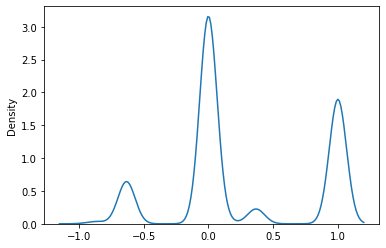

In [82]:
sns.kdeplot(df.score.values);